In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/Users/hanschristiangregersen/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# init graph
G = nx.Graph()

# add authors as vertices with productivity as attribute.
with open("author_productivity.txt", 'r') as f:
    count_authors = 0
    for line in f:
        author, productivity = line.split(" ")
        productivity = productivity.replace("\n", "")
        author, productivity = map(lambda x: int(x), [author, productivity])
        G.add_node(author, productivity=productivity)
        count_authors += 1

# add weighted edges to graph where weight is number of papers written together.
with open("collab_graph_weighted.txt", 'r') as f:
    count_collabs = 0
    for line in f:
        line = line.replace("\n", "")
        u, remaining = line.split(' ')
        v, weight = remaining.split('\t')
        u, v, weight = map(lambda x : int(x), [u,v,weight])
        G.add_edge(u, v, weight=weight)
        count_collabs += 1

print("There was {} authors, and {} collaborations".format(count_authors, count_collabs))
print("Graph has {} nodes, and {} edges".format(G.number_of_nodes(), G.number_of_edges()))

There was 9204 authors, and 20866 collaborations
Graph has 9204 nodes, and 20866 edges


In [6]:
# store productivity of every author in an array
author_productivity = nx.get_node_attributes(G, 'productivity')

# create a dataframe where each entry represents an author, her productivity and the number of authors with
# whom she has collaborated. 
data = np.empty((9204, 2))
# init ids 
for id in range(9204):
    data[id][0] = author_productivity[id]
    data[id][1] = len(G[id])
author_frame = pd.DataFrame(data=data, columns=['productivity', 'collaborators'])

# show statistics
author_frame.describe()

,productivity,collaborators
count,9204.000000,9204.000000
mean,6.300087,4.534116
std,10.227953,5.980957
min,1.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,3.000000
75%,7.000000,5.000000
max,172.000000,65.000000


We see that the most productive author has produced 171 papers, and the most collaborative author has collaborated with 65 other authors. Let's figure out if this is the same person. 

In [17]:
most_productive = filter(lambda (n,d): d['productivity'] == 172, G.nodes(data=True))[0][0]
most_collaborative = filter(lambda x: len(G[x]) == 65, G.nodes())[0]
print("most productive author(s) is {}".format(most_productive))
print("most collaborative author(s) is {}".format(most_collaborative))
print("Most productive author collaboated with {} other authors".format(int(author_frame.iloc[most_productive]['collaborators'])))
print("Most collaborative authors produced {} papers".format(int(author_frame.iloc[most_collaborative]['productivity'])))

most productive author(s) is 1095
most collaborative author(s) is 4409
Most productive author collaboated with 51 other authors
Most collaborative authors produced 108 papers


Hence, the most productive author is not the most collaborative, and the most collaborative author is not even close to being the most productive. Hence, having a lot of collaborators alone doesn't seem to automatically mean that you're most productive - perhaps your place in the network is also important i.e. with whom you're collaborating.

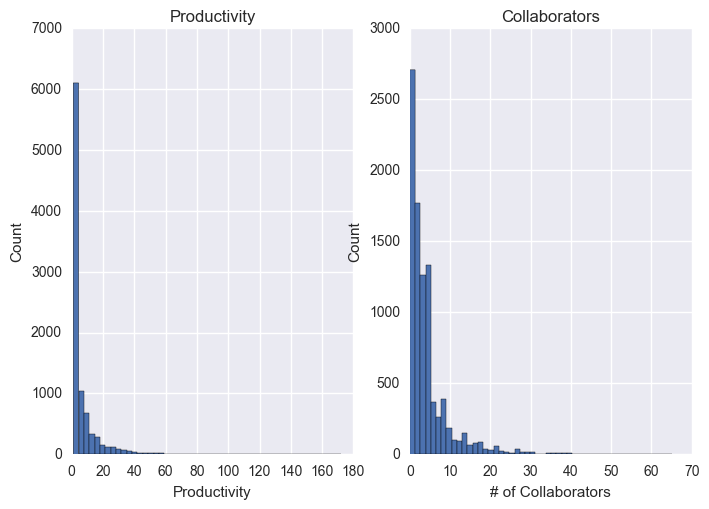

In [18]:
# let's visualize the distribution of productivity and number of collaborators
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(author_frame['productivity'], bins=50)
ax1.set_title("Productivity")
ax1.set_xlabel("Productivity")
ax1.set_ylabel("Count")
ax2.hist(author_frame['collaborators'], bins=50)
ax2.set_title("Collaborators")
ax2.set_xlabel("# of Collaborators")
ax2.set_ylabel("Count")
plt.show()

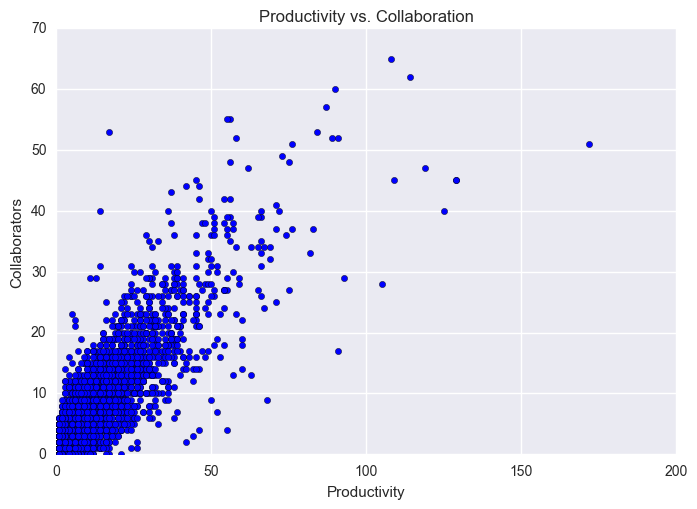

In [19]:
# let's visualize the relation between productivity and collaborators. 
plt.scatter(x=author_frame["productivity"], y=author_frame["collaborators"])
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.title("Productivity vs. Collaboration")
plt.xlabel("Productivity")
plt.ylabel("Collaborators")
plt.show()

Clearly there's a correlation between productivity and number of collaborators, as you'd expect. If you have many collaborators, trivially, your productivity will go up. 

Idea: we might need to adjust for this further on when examining the relation between centrality and productivity. 

In [20]:
# Graph Statistics 

# first let's count the number of isolated vertices. 
isolated_vertices = nx.isolates(G)
print("there are {} isolated nodes in the graph".format(len(isolated_vertices)))

# 

# clustering coefficient 
average_clustering_coefficient = nx.average_clustering(G)
print("Average Clustering Coefficient {}".format(average_clustering_coefficient))



there are 824 isolated nodes in the graph
Average Clustering Coefficient 0.414939976733


Hence, the graph is not connected and there are 901 lone wolfs out there. On average 40% of any author's collaborators, have also collaborated. However, note that sometimes there a multiple authors collaborating on the same paper, so this number might just be a reflection of this fact. 

In [24]:
graphs = list(nx.connected_component_subgraphs(G))

print("number of connected components: {}".format(len(graphs)))
n_nodes_largest_c = max((map(lambda x : x.number_of_nodes(), graphs)))
print("larges connected component: {}".format(n_nodes_largest_c))
fraction = n_nodes_largest_c / float(G.number_of_nodes())
print("fraction of authors belonging to lage connected component {}".format(fraction))



number of connected components: 1234
larges connected component: 7237
fraction of authors belonging to lage connected component 0.786288570187


Hence, there is a giant connected component comprising 78 percent of all authors. The following is a list of stats on this component.

In [ ]:
largest_component = sorted(graphs, key=len, reverse=True)[0]

nodes_centrality_between = nx.betweenness_centrality(largest_component)